In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [7]:
def randomized_local_search(
    objective_function,
    starting_point,
    max_iterations=100,
    step_size=0.5,
    probability=0.2,
    bounds=None,
    verbose=False,
    log_path=False
):
    """
    Універсальний алгоритм випадкового локального пошуку з логуванням.

    Параметри:
        objective_function: функція, яку потрібно мінімізувати (f(x) -> float)
        starting_point: початкова точка (list/tuple/np.array)
        max_iterations: кількість ітерацій
        step_size: максимальний розмір кроку
        probability: імовірність прийняти гірше рішення
        bounds: межі [(min1, max1), (min2, max2), ...] або None
        verbose: якщо True — показує прогрес у консолі
        log_path: якщо True — повертає історію пошуку

    Повертає:
        best_point, best_value, history (якщо log_path=True)
    """
    current_point = np.array(starting_point, dtype=float)
    current_value = objective_function(current_point)

    # лог для траєкторії
    history = [(current_point.copy(), current_value)]

    for i in range(max_iterations):
        # випадковий сусід
        new_point = current_point + np.random.uniform(-step_size, step_size, size=len(current_point))

        # обмеження межами
        if bounds is not None:
            for j, (low, high) in enumerate(bounds):
                new_point[j] = np.clip(new_point[j], low, high)

        new_value = objective_function(new_point)

        # прийняття рішення
        if new_value < current_value or random.random() < probability:
            current_point, current_value = new_point, new_value

        # логування
        history.append((current_point.copy(), current_value))

        if verbose and i % 10 == 0:
            print(f"Ітерація {i:4d} | Поточне значення: {current_value:.6f}")

    if log_path:
        return current_point, current_value, history
    else:
        return current_point, current_value


In [8]:
def business_loss(x,
    base_rev_per_user=15.0,
    alpha=12.0,   # сила миттєвого ефекту бонусу
    beta=1.2,     # швидкість насичення миттєвого ефекту
    gamma=4.0,    # коефіцієнт майбутньої вартості (LTV) за бонус
    c1=1.5,       # лінійні витрати на бонус
    c2=0.3):      # квадратичні витрати (ріст витрат при великих бонусах)
    """
    x: [bonus, activity]
    Повертає scalar loss (менше — краще).
    Параметри дають контроль над формою кривої.
    """
    bonus, activity = x
    bonus = float(bonus)
    activity = float(activity)

    # 1) Базовий дохід від активності (без бонусу)
    base_revenue = base_rev_per_user * activity

    # 2) Миттєвий ефект бонусу: має вигляд  alpha * (1 - exp(-beta * bonus)) * activity
    #    — швидкий підйом при малих bonus, насичення при великих
    immediate_revenue = alpha * (1 - np.exp(-beta * bonus)) * activity

    # 3) Майбутній ефект (LTV/утримання): припустимо, лінійна вигода від невеликого bonus
    future_revenue = gamma * bonus * activity

    total_revenue = base_revenue + immediate_revenue + future_revenue

    # 4) Витрати: лінійні + квадратичні частини
    cost = c1 * bonus + c2 * bonus**2

    # 5) Втрати від неактивності (підкреслює важливість activity)
    inactivity_loss = (1 - activity)**2 * 8.0

    # Підсумок: втрати = витрати + неефективність - дохід
    loss = cost + inactivity_loss - total_revenue
    return loss

In [9]:
best_point, best_value, history = randomized_local_search(
    objective_function=business_loss,
    starting_point=[0, 0],
    max_iterations=200,
    step_size=0.4,
    probability=0.1,
    # bounds=[(-10, 10), (-10, 10)],
    verbose=True,
    log_path=True
)

Ітерація    0 | Поточне значення: 8.000000
Ітерація   10 | Поточне значення: -20.886133
Ітерація   20 | Поточне значення: -38.764133
Ітерація   30 | Поточне значення: -39.720800
Ітерація   40 | Поточне значення: -68.886012
Ітерація   50 | Поточне значення: -82.967975
Ітерація   60 | Поточне значення: -79.103584
Ітерація   70 | Поточне значення: -95.046750
Ітерація   80 | Поточне значення: -97.103719
Ітерація   90 | Поточне значення: -106.938002
Ітерація  100 | Поточне значення: -115.625610
Ітерація  110 | Поточне значення: -115.196038
Ітерація  120 | Поточне значення: -120.521312
Ітерація  130 | Поточне значення: -129.091692
Ітерація  140 | Поточне значення: -142.032776
Ітерація  150 | Поточне значення: -152.059629
Ітерація  160 | Поточне значення: -164.258857
Ітерація  170 | Поточне значення: -171.244642
Ітерація  180 | Поточне значення: -181.583585
Ітерація  190 | Поточне значення: -184.175268


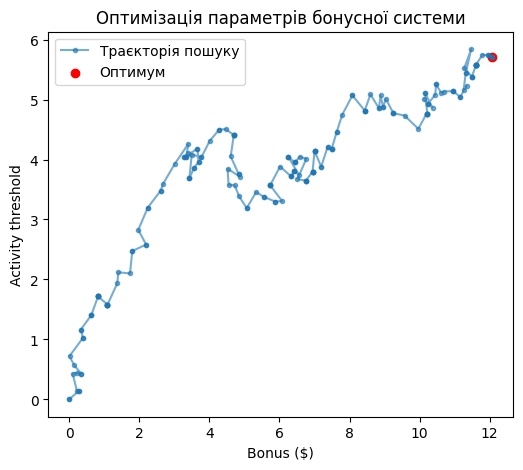

In [10]:
xs, ys, zs = zip(*[(p[0], p[1], v) for p, v in history])
plt.figure(figsize=(6, 5))
plt.plot(xs, ys, marker='.', alpha=0.6, label="Траєкторія пошуку")
plt.scatter(best_point[0], best_point[1], color='red', label='Оптимум')
plt.title("Оптимізація параметрів бонусної системи")
plt.xlabel("Bonus ($)")
plt.ylabel("Activity threshold")
plt.legend()
plt.show()